# Disaster Tweet - Real or Not

Tweets are a the new way of expressing emotions, sharing news, promoting brands etc. It has also become a strong force that enables people let their voices/feelings known to a company, Government or to the whole world.

People often take to such social media platforms to share something. But given the volume of tweets, its often difficult to quickly identify whether a tweet is alarming something.

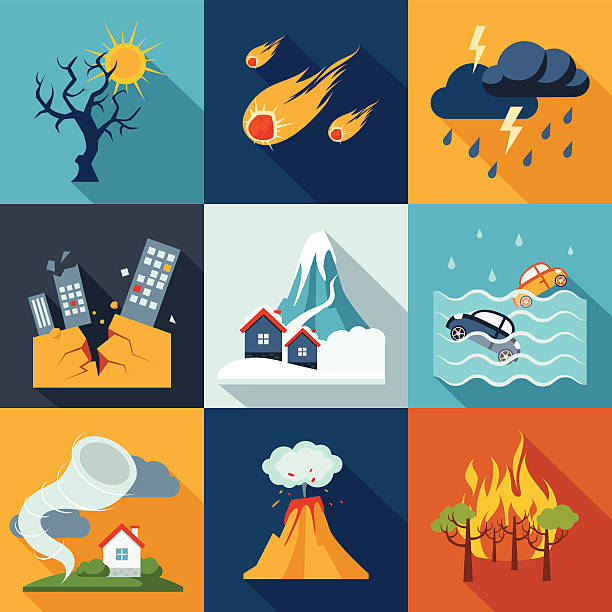

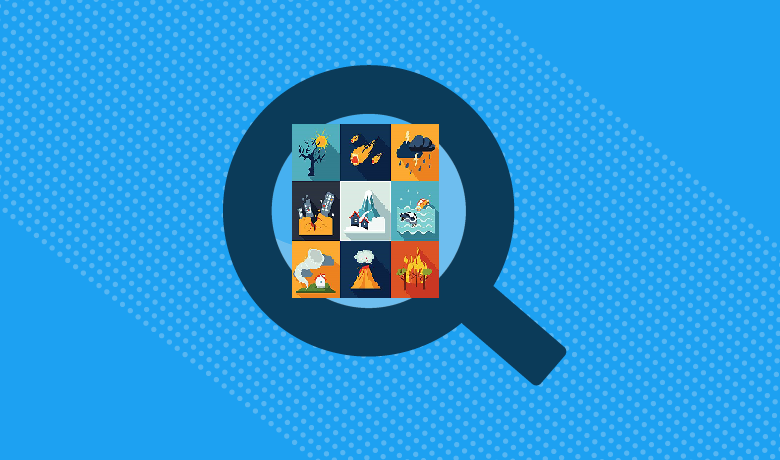

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.svm import SVC
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
from nltk.tokenize import word_tokenize
import re
import warnings 

stop=set(stopwords.words('english'))
warnings.filterwarnings("ignore")
%matplotlib inline

## Read the files

In [ ]:
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

### Quick Peak into the data

In [ ]:
print('Train Data size :{}'.format(train_df.shape))
print('Test Data size :{}'.format(test_df.shape))

In [ ]:
train_df.head()

#### Tweets missing the keyword & location

In [ ]:
train_df.isna().sum()

In [ ]:
test_df.isna().sum()

- Only a few tweets are missing keyword. This can be considered in the analysis
- Approx. 33% of tweets are missing the location. We will analyze the rest 67% to see if any information can be extracted

In [ ]:
train_df.groupby('location')['id'].count()

- Location data seems to have place name, coordinates & unreadable characters as well.
- Seems it can't be used as is & needs good amount of preprocessing.
- Let's park it aside for now

## Tweets Distribution

### Target Distribution

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(6,6))
x=train_df['target'].value_counts()
sns.barplot(x.index,x)

- Not so imbalanced dataset

#### Do people go for lengthy tweets in case of disaster?? 
Well it depends on whether the person is talking about the disaster Vs reporting a disaster. Ideally, the first category would have lengthy tweets compared to the later

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
char_len = train_df[train_df['target']==1]['text'].str.len()
sns.distplot(char_len,ax=axes[0],kde=False)

char_len = train_df[train_df['target']==0]['text'].str.len()
sns.distplot(char_len,ax=axes[1],kde=False)

- Both categories have more or less same char length , lengthy tweets.
- Seems people who tweeted about disaster were talking about it than reporting from ground 0.

### Keywords mostly used in each category

#### Let's look at the top 10 keywords

In [ ]:
fig,axes= plt.subplots(2,1,figsize=(18,12))

temp = pd.DataFrame(train_df[train_df['target']==0].groupby('keyword')['id'].count())
temp.sort_values('id',ascending=False,inplace=True)
sns.barplot(temp.index[:10],temp['id'][:10],ax=axes[0]).set_title('Normal Tweets')


temp = pd.DataFrame(train_df[train_df['target']==1].groupby('keyword')['id'].count())
temp.sort_values('id',ascending=False,inplace=True)
sns.barplot(temp.index[:10],temp['id'][:10],ax=axes[1]).set_title('Disaster Tweets')

- Based on the top keywords in each category, it can be safely considered that keyword tell us about a disaster tweet to some extent.
- Tweets in the disaster category seems to be around
    - Train accident
    - Oil spill in the ocean, accident/damage to a ship
    - Suicide bomb attack
    - Outbreak of a virus or a disease
    - Typhoon

## Hash Tags

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time.Lets check the hashtags to see if they have something else to say

In [ ]:
# Referenec : https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

HT_regular = hashtag_extract(train_df['text'][train_df['target'] == 0])

# extracting hashtags from racist/sexist tweets
HT_disaster = hashtag_extract(train_df['text'][train_df['target'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_disaster = sum(HT_disaster,[])

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(18,10))

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
sns.barplot(data=d, x= "Hashtag", y = "Count",ax=axes[0]).set_title('Normal Tweets')


a = nltk.FreqDist(HT_disaster)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
sns.barplot(data=d, x= "Hashtag", y = "Count",ax=axes[1]).set_title('Disaster Tweets')



- Story seems to be different here. While news hashtag can be ignored, certain hashtags seems to tell us about locations like Japan, India. Probably places linked to disasters
- Hiroshima  - Are they talking about the Hiroshima Nagasaki incident here??

## Time to clean the actual text

<font color=blue> Merge the train & test to process everything atonce </font>

In [ ]:
Merge_df = train_df.append(test_df,ignore_index=True)

#### Define function to remove patterns

In [ ]:
def remove_pattern(input_txt, pattern):
    reg_obj = re.compile(pattern)
    input_txt = reg_obj.sub(r'', input_txt)
        
    return input_txt   

### Remove twitter handles

In [ ]:
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x,"@[\w]*"))



### Remove URLs, http tags

In [ ]:
# Reference : https://www.kaggle.com/shahules/tweets-complete-eda-and-basic-modeling

Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x,'https?://\S+|www\.\S+'))
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x,'<.*?>'))
    

### Remove punctuations, special characters, numbers

In [ ]:
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x,"[^a-zA-Z# ]"))

### Remove Stop words

In [ ]:
def remove_stop_words(text):
    
    word_tokens = word_tokenize(text) 
  
    filtered_sentence = [w for w in word_tokens if not w in stop] 
    
    filtered_tweet = ' '.join(filtered_sentence)
    
    return filtered_tweet

In [ ]:
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_stop_words(x))

### Tokenize & Stemming

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize_stem(text):
    
    token_words = word_tokenize(text)
    stem_words =[]
    for i in token_words:
        word = lemmatizer.lemmatize(i)
        stem_words.append(word)
        
    final_tweet = ' '.join(stem_words)
    
    return final_tweet

In [ ]:
Merge_df['text'] = Merge_df['text'].apply(lambda x: tokenize_stem(x))

## Word Cloud

#### Word cloud for Normal tweets

In [ ]:
all_words = ' '.join([text for text in Merge_df['text'][Merge_df['target']==0]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Word cloud for Disaster Tweets

In [ ]:
all_words = ' '.join([text for text in Merge_df['text'][Merge_df['target']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Clearly the word cloud says it all.

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=300, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(Merge_df['text'])

In [ ]:
tfidf.shape

## Model Building

In [ ]:
Final_train = tfidf[:7613]
Final_test = tfidf[7613:]

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

xtrain = Final_train[:5331]
xvalid = Final_train[5331:]
ytrain = Merge_df[:5331]['target']
yvalid = Merge_df[5331:7613]['target']

parameter = {'solver':['liblinear','lbfgs'],
            'max_iter':[200,400]}

Logis_clf = LogisticRegression()

lreg = GridSearchCV(Logis_clf, param_grid = parameter, cv = 3, verbose=True, n_jobs=-1)
lreg.fit(xtrain, ytrain) # training the model

prediction = lreg.predict_proba(xvalid) # predicting on the validation set

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,f1_score, confusion_matrix


# keep probabilities for the positive outcome only
lr_probs = prediction[:, 1]
lr_auc = roc_auc_score(yvalid, lr_probs)


print('ROC AUC=%.3f' % (lr_auc))

lr_fpr, lr_tpr, _ = roc_curve(yvalid, lr_probs)

# plot the roc curve for the model
plt.figure(figsize=(10,8))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Consider 0.4 as cut-off for consider probability as 1

In [ ]:
prediction_int = prediction[:,1] >= 0.35
prediction_int = prediction_int.astype(np.int)
f1score = f1_score(yvalid,prediction_int)
print('F1 Score : %.3f' %(f1score))
conf = confusion_matrix(yvalid,prediction_int)
print(conf)

## Test against the 'Test Data'

In [ ]:
prediction = lreg.predict_proba(Final_test) # predicting on the test set

prediction_int = prediction[:,1] >= 0.35
prediction_int = prediction_int.astype(np.int)

### Naive Bayes

In [ ]:
NB_Clf = MultinomialNB()
NB_Clf.fit(xtrain, ytrain)

pred_naive = NB_Clf.predict(xvalid)
conf = confusion_matrix(yvalid, pred_naive)
print(conf)

f1score = f1_score(yvalid,pred_naive)
print('F1 Score : %.3f' %(f1score))

pred_naive_test = NB_Clf.predict(Final_test)
pred_naive_test = pred_naive_test.astype(int)



### SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
SVM_Model = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, n_jobs=-1).fit(xtrain, ytrain)

In [ ]:
pred_SVM_valid = SVM_Model.predict(xvalid)
pred_SVM_valid = pred_SVM_valid.astype(int)

conf = confusion_matrix(yvalid, pred_SVM_valid)
print(conf)

f1score = f1_score(yvalid,pred_SVM_valid)
print('F1 Score : %.3f' %(f1score))

### Final Submission File

In [ ]:
test_df['target'] = prediction_int

Final_submission= test_df[['id','target']]
Final_submission.to_csv('submission.csv',index=False)

****Please upvote if you find this kernel interesting/useful**